# Naive recalculation based on predicitve power

## Preliminaries

In [1]:
if (!require("renv")) 
    install.packages("renv") 

suppressPackageStartupMessages({
    renv::restore(lockfile = "../renv.lock")
    library(tidyverse)
    library(patchwork)
    # library(truncnorm)
})

set.seed(42)
source("../R/util.R")
dir.create("../output/figures", recursive = TRUE, showWarnings = FALSE)

options(repr.plot.width = 12, repr.plot.height = 5)

Loading required package: renv


Attaching package: ‘renv’


The following object is masked from ‘package:stats’:

    update


The following objects are masked from ‘package:utils’:

    history, upgrade


The following objects are masked from ‘package:base’:

    load, remove




* The library is already synchronized with the lockfile.


In [2]:
prior <- TruncatedNormal(mu = 0.4, tau = 0.2, a = -0.5, b = 1.0)
alpha <- 0.025
 crit <- qnorm(1 - alpha)
 beta <- 0.2

n <- 1
while (expected_power(n, crit, prior) < 1 - beta) {
    n <- n + 1
}
cat(sprintf("required n: %i, expected power: %6.2f", n, 100*expected_power(n, crit, prior)))

m <- round(n/3) # 26, interim time-point

required n: 79, expected power:  80.07

## Back to example: recalculation?

This unplanned interim analysis could have two of the following goals:

1. Adjust the final sample size to $n'<n_{max}$ such that the probability of rejecting the null at the end of the trial given the data observed so far is sufficiently large without violating strict type one error rate control.
2. Assess the prospects of reaching the study goal after recruiting all $n'$ individuals and stop the trial for futility if the chances are too small. Early futility stopping never incurs a type one error rate penalty!

The first problem can be addressed by solving

\begin{align}
    \operatorname{argmin}(n', c') \quad & n' \\
    \text{ subject to} \quad & \PP_{n'}(z_m, c') \geq 1 - \beta \\
                      &  \CP_{n'}(z_m, c', 0) \leq \CP(z_m, \crit, 0) \\
                      &  m <= n'_{min} \leq n' \leq n_{max} \ . 
\end{align}

Here, the first condition ensures that *the probability of rejecting the null at the end of the trial given the data observed so far is sufficiently large* while the second condition ensures type one error rate control via the conditional error principle and the third ensures that the upper sample size boundary is respected (and we don't go back in time). 
The lower boundary $n'_{min}$ is set to ensure a minimal sample size for the remaining study (otherwise operation costs not justified).

Note that 

* Requirement (1.) naturally leads to the use of predictive power, conditional power is only used to evaluate the conditional type one error rate since this is not affected by uncertainty.
* When the lower boundary is hit, the critical value is not identifieable from the above given formulation. In that case we just $\CP_{n_min}(z_m, c', 0) = \CP(z_m, \crit, 0)$ for the given sample $n_min$ size to obtain the adjusted critical value.

Assume that $n'_{min} = 30, n_{max} = 160$ and $1-\beta=0.8$.

In [3]:
n_min <- 30
n_max <- 160

In [4]:
adapt_naive <- function(m, zm, beta_cond, n_min, n_max, n_old, c_old) {
    # old conditonal error
    alpha_bar <- conditional_power(zm, m, n_old, c_old, 0)
    target <- function(x) {
        n_bar <- x[1]; c_bar <- x[2]
        (conditional_power(zm, m, n_bar, c_bar, 0) - alpha_bar)^2 + 
            (predictive_power(zm, m, n_bar, c_bar, prior) - (1 - beta_cond))^2
    }
    res <- optim(
        par = c(n, crit), 
        fn = target, 
        lower = c(n_min, 0), 
        upper = c(n_max, 5), 
        method = "L-BFGS-B",
        control = list(fnscale = 1e-4, parscale = c((n_max + n_min)/2, 1))
    )
    
    list(
        n = if (abs(res$par[1] - n_max) < 0.1) m else res$par[1],
        c = if (abs(res$par[1] - n_max) < 0.1) Inf else res$par[2],
        optim = res
    )
}
        
tbl_adapted <- tibble(
        zm = seq(0.0, 3.5, by = 0.01),
    design = "adapted",
       tmp = map(zm, function(zm) {
            res <- adapt_naive(m, zm, beta_cond = 0.2, n_min = n_min, n_max = n_max, n_old = n, c_old = crit)
            tibble(n = res$n, c = res$c)
        }
    )
) %>%
unnest(tmp) %>%
bind_rows(
    tibble(
        zm = seq(0.0, 3.5, by = 0.01),
    design = "original",
         n = n,
         c = crit
    )
) %>%
mutate(
         PP = pmap_dbl(list(zm, n, c), ~predictive_power(..1, m, ..2, ..3, prior)),
    section = if_else(c == Inf, "early futility", "continue"),
     design = factor(design, levels = c("original", "adapted"))
)

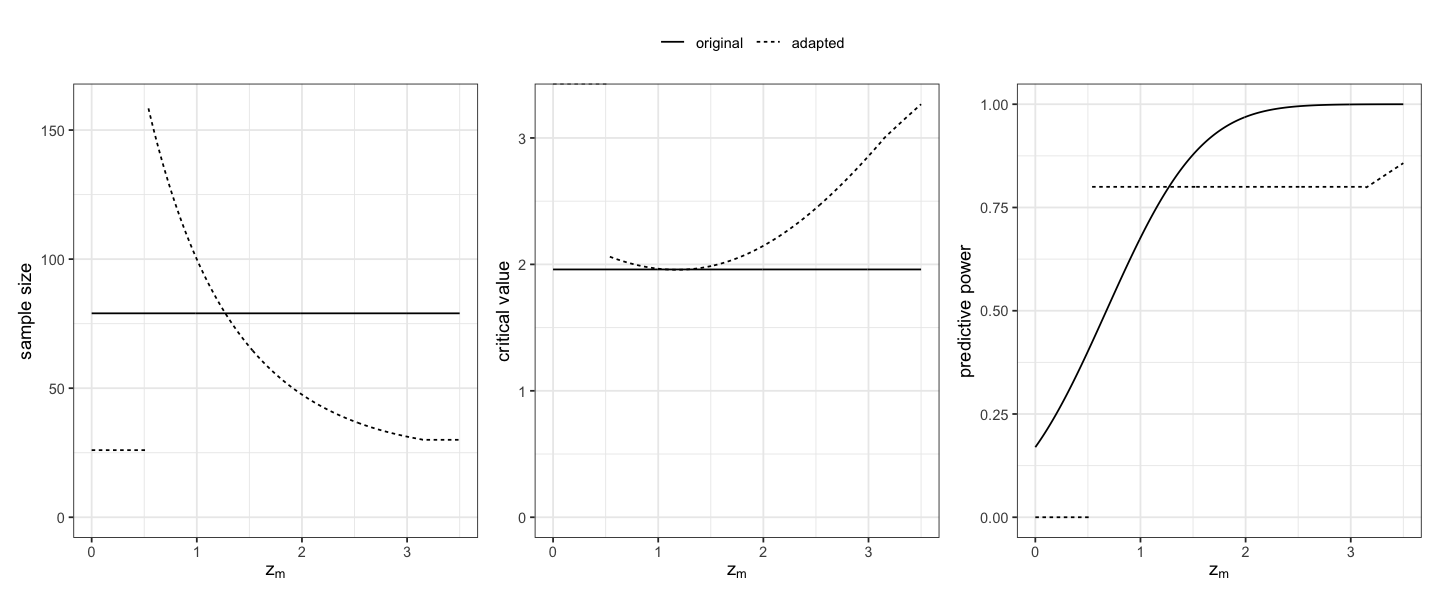

In [5]:
plt1 <- ggplot(tbl_adapted) +
    aes(zm, n, group = interaction(section, design)) +
    geom_line(aes(linetype = design)) +
    scale_x_continuous(expression(z[m]), limits = c(0, 3.5)) +
    scale_y_continuous('sample size', limits = c(0, n_max)) +
    scale_linetype('') +
    theme_bw() +
    theme(
        legend.position = "top"
    )

plt2 <- ggplot(tbl_adapted) +
    aes(zm, c, group = interaction(section, design)) +
    geom_line(aes(linetype = design)) +
    scale_x_continuous(expression(z[m]), limits = c(0, 3.5)) +
    scale_y_continuous('critical value', limits = c(0, NA)) +
    scale_linetype('') +
    theme_bw() +
    theme(
        legend.position = "top"
    )

plt3 <- ggplot(tbl_adapted) +
    aes(zm, PP, group = interaction(section, design)) +
    geom_line(aes(linetype = design)) +
    scale_x_continuous(expression(z[m]), limits = c(0, 3.5)) +
    scale_y_continuous('predictive power') +
    scale_linetype('') +
    theme_bw() +
    theme(
        legend.position = "top"
    )

plt1 + plt2 + plt3 + plot_layout(guides = "collect") & theme(legend.position = 'top')

## Properties of the binding recalculation design

We now look at the properties of the two-stage design that results from making the above recalculation procedure binding.

In [6]:
a <- tbl_adapted %>% 
    filter(design == "adapted", section == "early futility") %>% 
    arrange(desc(zm)) %>% 
    pull(zm) %>% 
    head(1)
pr_a <- predictive_cdf(prior, m, a)

b <- tbl_adapted %>% 
    filter(design == "adapted", n == n_min) %>% 
    arrange(zm) %>% 
    pull(zm) %>% 
    head(1)
pr_b <- 1 - predictive_cdf(prior, m, b)

In [7]:
ess <- pr_a * m +
    integrate_gl(
        function(zm) {
            map_dbl(
                zm, 
                ~predictive_pdf(prior, m, .) * 
                    adapt_naive(m, ., beta_cond = 0.2, n_min = n_min, n_max = n_max, n_old = n, c_old = crit)$n
            )
        }, 
        a, b
    ) +  
    pr_b * n_min

print(ess)

[1] 49.52722


In [8]:
esssq <- pr_a * m^2 +
    integrate_gl(
        function(zm) {
            map_dbl(
                zm, 
                ~predictive_pdf(prior, m, .) * 
                    adapt_naive(m, ., beta_cond = 0.2, n_min = n_min, n_max = n_max, n_old = n, c_old = crit)$n^2
            )
        }, 
        a, b
    ) +  
    pr_b * n_min^2

sqrt(esssq - ess^2)

[1] 29.70282

In [9]:
toer <- integrate_gl(
        function(zm) {
            map_dbl(
                zm, 
                ~dnorm(., 0, 1) * conditional_power(
                        ., m, 
                        n = adapt_naive(m, ., beta_cond = 0.2, n_min = n_min, n_max = n_max, n_old = n, c_old = crit)$n,
                        c = adapt_naive(m, ., beta_cond = 0.2, n_min = n_min, n_max = n_max, n_old = n, c_old = crit)$c, 
                    theta = 0
                )
            )
        } ,
        a, 10
    )

print(toer)

[1] 0.02076664


In [10]:
ep <- integrate_gl(
        function(zm) {
            map_dbl(
                zm, 
                ~predictive_pdf(condition(prior, 0), m, .) * predictive_power(
                        ., m, 
                        n = adapt_naive(m, ., beta_cond = 0.2, n_min = n_min, n_max = n_max, n_old = n, c_old = crit)$n,
                        c = adapt_naive(m, ., beta_cond = 0.2, n_min = n_min, n_max = n_max, n_old = n, c_old = crit)$c, 
                    prior = condition(prior, 0)
                )
            )
        } ,
        a, 10
    )

print(ep)

[1] 0.7213767


# Optimal two-stage designs

In [11]:
suppressPackageStartupMessages({
    library(adoptr)
})

In [12]:
   H0 <- PointMassPrior(.0, 1)
   H1 <- ContinuousPrior(function(theta) dnorm(theta, 0.4, 0.2)/(pnorm(1, 0.4, 0.2) - pnorm(-0.5, 0.4, 0.2)), c(-0.5, 1))
  ESS <- ExpectedSampleSize(Normal(two_armed = FALSE), H1)
    n <- ConditionalSampleSize()
ESSSq <- expected(composite({n^2}), Normal(two_armed = FALSE), H1)
 SDSS <- composite({sqrt(ESSSq - ESS^2)})
   EP <- Power(Normal(two_armed = FALSE), adoptr::condition(H1, c(0, 1)))
 TOER <- Power(Normal(two_armed = FALSE), H0)
   PP <- ConditionalPower(Normal(two_armed = FALSE), adoptr::condition(H1, c(0, 1)))
   CE <- ConditionalPower(Normal(two_armed = FALSE), H0)

In [13]:
optimal_design <- minimize(
    ESS,
    subject_to(
          EP >= 0.8,
        TOER <= 0.025
    ),
    get_initial_design(
        theta = .4,
        alpha = .025,
        beta  = .2,
        type  = 'two-stage',
        dist  = Normal(two_armed = FALSE),
        order = 11L
    )
)$design

In [14]:
tbl_optimal_design <- tibble(
         zm = seq(0, 3.5, by = 0.01),
     design = "optimal",
          n = n(optimal_design, zm, round = FALSE),
         c2 = c2(optimal_design, zm),
        # transform stage two critical value to overall critical value
          c = sqrt(n - n1(optimal_design)) / sqrt(n) * c2 + sqrt(n1(optimal_design)/n) * zm,
         PP = evaluate(PP, optimal_design, zm),
    section = case_when(
            c ==  Inf ~ 'early futility',
            c == -Inf ~ 'early efficacy',
                 TRUE ~ 'continue'
        )
) %>% 
select(
    -c2
) %>% 
mutate(
    PP = pmap_dbl(list(zm, n, c), ~predictive_power(..1, m, ..2, ..3, prior))
)

tbl_designs <- bind_rows(
    tbl_optimal_design,
    tbl_adapted
) %>%
mutate(
    design = factor(design, levels = c("original", "adapted", "optimal"))
)

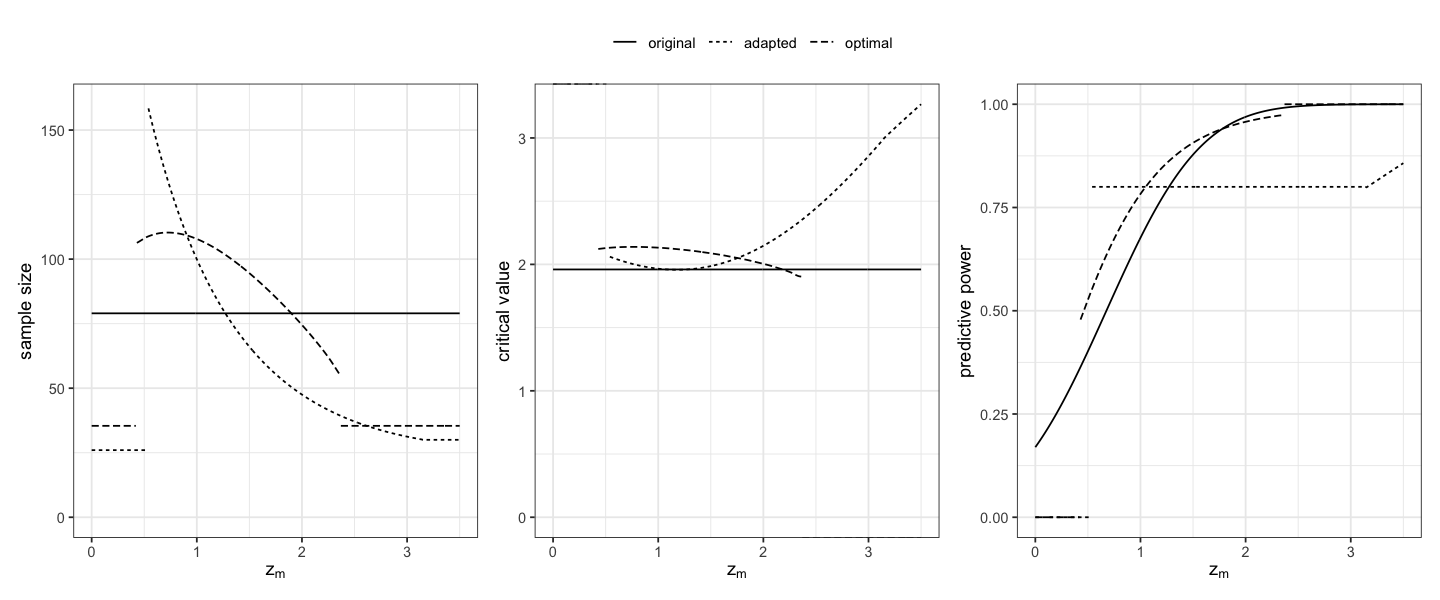

In [15]:
plt1 <- ggplot(tbl_designs) +
    aes(zm, n, group = interaction(section, design)) +
    geom_line(aes(linetype = design)) +
    scale_x_continuous(expression(z[m]), limits = c(0, 3.5)) +
    scale_y_continuous('sample size', limits = c(0, n_max)) +
    scale_linetype('') +
    theme_bw() +
    theme(
        legend.position = "top"
    )

plt2 <- ggplot(tbl_designs) +
    aes(zm, c, group = interaction(section, design)) +
    geom_line(aes(linetype = design)) +
    scale_x_continuous(expression(z[m]), limits = c(0, 3.5)) +
    scale_y_continuous('critical value', limits = c(0, NA)) +
    scale_linetype('') +
    theme_bw() +
    theme(
        legend.position = "top"
    )

plt3 <- ggplot(tbl_designs) +
    aes(zm, PP, group = interaction(section, design)) +
    geom_line(aes(linetype = design)) +
    scale_x_continuous(expression(z[m]), limits = c(0, 3.5)) +
    scale_y_continuous('predictive power') +
    scale_linetype('') +
    theme_bw() +
    theme(
        legend.position = "top"
    )

plt1 + plt2 + plt3 + plot_layout(guides = "collect") & theme(legend.position = 'top')

In [16]:
ggsave("../output/figures/naive_adaptive_and_optimal_designs.pdf", width = 8, height = 3.5)

In [17]:
summary(optimal_design, `ESS` = ESS, `SDSDD` = SDSS, `mTOER` = TOER, `Expected Power` = EP)

TwoStageDesign: n1 =  35 
                futility |                              continue                             | efficacy
            x1:     0.42 |  0.45  0.53  0.69  0.89  1.13  1.40  1.66  1.90  2.11  2.26  2.35 |  2.37
        c2(x1):     +Inf | +2.28 +2.22 +2.12 +1.98 +1.80 +1.58 +1.32 +1.02 +0.69 +0.35 +0.08 |  -Inf
        n2(x1):        0 |    71    73    75    74    70    63    53    43    34    26    21 |     0
           ESS:     56.421
         SDSDD:     28.547
         mTOER:      0.025
Expected Power:      0.799


In [18]:
write_rds(optimal_design, path = "optimal_design.RDS")

## Find Lagrange multiplier $\lambda$

In [50]:
f <- function(lambda) {
    minimize(
        composite({ESS - lambda*EP}),
        subject_to(
            TOER <= 0.025
        ),
        get_initial_design(
            theta = .4,
            alpha = .025,
            beta  = .2,
            type  = 'two-stage',
            dist  = Normal(two_armed = FALSE),
            order = 11L
        ),
        opts = list(algorithm = "NLOPT_LN_COBYLA", xtol_rel = 1e-05, maxeval = 5e4)
    )$design
}

In [48]:
library(future)
plan(multisession)

In [51]:
# we can use a crude distance metric to quickly find a lambda that approximately reproduces the original design
tbl_lambda <- tibble(
    lambda = seq(200, 300, by = 5),
    design = map(lambda, ~future({f(.)})) # spawn futures
) %>% 
mutate(
    design = map(design, value), # collect futures
     # delta = map_dbl(design, ~sum((c(.@n1, .@n2_pivots) - c(optimal_design@n1, optimal_design@n2_pivots))^2))
     delta = map_dbl(design, ~(evaluate(EP, .) - 1 + beta)^2)
)

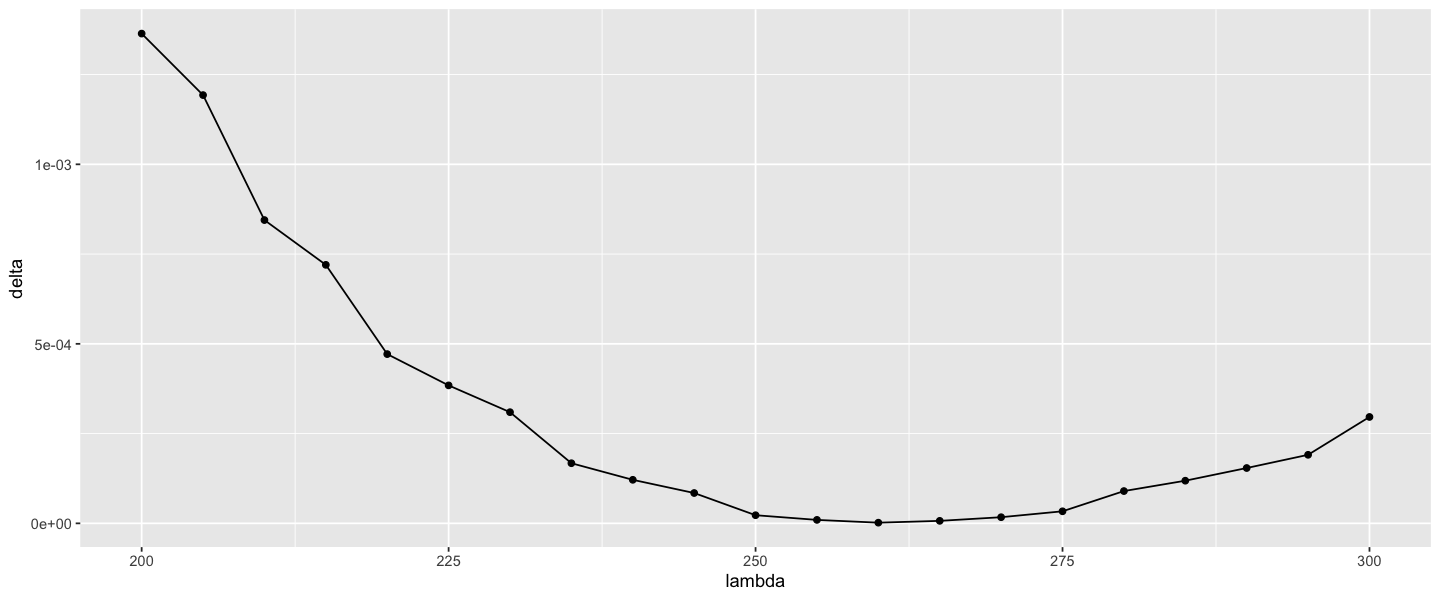

In [52]:
tbl_lambda %>% 
    ggplot() +
        aes(lambda, delta) +
        geom_line() +
        geom_point()

In [53]:
tbl_lambda %>% 
    arrange(delta) %>% {
        lambda <<- pull(., lambda) %>% .[[1]] 
        .
    } %>%
    pull(design) %>% 
    .[[1]] %>%
    summary(`ESS` = ESS, `SDSDD` = SDSS, `mTOER` = TOER, `Expected Power` = EP)

TwoStageDesign: n1 =  35 
                futility |                              continue                             | efficacy
            x1:     0.43 |  0.45  0.54  0.69  0.89  1.14  1.40  1.66  1.90  2.11  2.26  2.35 |  2.37
        c2(x1):     +Inf | +2.28 +2.22 +2.12 +1.98 +1.80 +1.58 +1.31 +1.01 +0.69 +0.35 +0.08 |  -Inf
        n2(x1):        0 |    71    73    75    74    69    62    53    43    34    26    20 |     0
           ESS:     56.315
         SDSDD:     28.413
         mTOER:      0.025
Expected Power:      0.799


In [63]:
write_rds(lambda, path = "lambda.RDS")